#  추천 시스템 - ETF 추천 로직

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

import warnings
warnings.filterwarnings('ignore')

`(3) SQLite DB`

In [3]:
from langchain_community.utilities import SQLDatabase

# ETF 데이터베이스 연결
db = SQLDatabase.from_uri(
    "sqlite:///etf_database.db",
    )

# 사용 가능한 테이블 목록 
print(db.dialect)
print(db.get_usable_table_names())
etfs = db.run("SELECT * FROM ETFs LIMIT 5;")

for etf in eval(etfs):
    print(etf)

sqlite
['ETFs', 'ETFsInfo']
('466400', '1Q 25-08 회사채(A+이상)액티브', '2023/09/19', '채권-회사채-단기', '하나자산운용', 4.52, 'KIS 2025-08만기형 크레딧 A+이상 지수(총수익)', 0.11, 111916276404.0, 0.03, '매우낮음', '실물(액티브)', 0.1, '배당소득세(보유기간과세)')
('491610', '1Q CD금리액티브(합성)', '2024/09/24', '기타', '하나자산운용', 0.0, 'KIS 하나 CD금리 총수익지수', 0.05, 316206006696.0, 0.02, '매우낮음', '합성(액티브)', 0.02, '배당소득세(보유기간과세)')
('451060', '1Q K200액티브', '2023/01/31', '주식-시장대표', '하나자산운용', -3.66, '코스피 200', 0.77, 99754348820.0, -0.01, '높음', '실물(액티브)', 0.18, '배당소득세(보유기간과세)')
('463290', '1Q 단기금융채액티브', '2023/08/03', '채권-혼합-단기', '하나자산운용', 4.01, 'MK 머니마켓 지수(총수익)', 0.05, 252717462257.0, 0.0, '매우낮음', '실물(액티브)', 0.08, '배당소득세(보유기간과세)')
('479080', '1Q 머니마켓액티브', '2024/04/02', '채권-혼합-단기', '하나자산운용', 0.0, 'KIS-하나 MMF 지수(총수익)', 0.06, 308255065986.0, -0.01, '매우낮음', '실물(액티브)', 0.05, '배당소득세(보유기간과세)')


`(4) SQL QA Chain`

-  DB 테이블에서 고유명사 추출

In [4]:
import ast
import re

def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


etfs = query_as_list(db, "SELECT DISTINCT 종목명 FROM ETFs")
fund_managers = query_as_list(db, "SELECT DISTINCT 운용사 FROM ETFs")
underlying_assets = query_as_list(db, "SELECT DISTINCT 기초지수 FROM ETFs")

print("ETFs:", len(etfs))
print("Fund Managers:", len(fund_managers))
print("Underlying Assets:", len(underlying_assets))

print(etfs[:5])
print(fund_managers[:5])
print(underlying_assets[:5])

ETFs: 925
Fund Managers: 26
Underlying Assets: 665
['TIGER 차이나전기차SOLACTIVE', 'RISE 미국나스닥100', 'TIGER 차이나CSI300인버스(합성)', 'ACE 국고채3년', 'TIGER 200에너지화학레버리지']
['한국투자밸류자산운용', '대신자산운용', '마이다스에셋', '교보악사자산운용', '삼성자산운용']
['KIS MSB 단기지수(총수익)', 'S&P Global  Health Care Index', 'FnGuide AI 반도체 소부장 지수', 'KAP 일본 단기 국채 지수(총수익)', 'FnGuide 전기&수소차 지수 (시장가격)']


- 고유명사를 벡터스토어에 저장

In [5]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

# 임베딩 모델 생성
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# 임베딩 벡터 저장소 생성
vector_store = InMemoryVectorStore(embeddings)

# ETF 종목명과 운용사를 임베딩 벡터로 변환
_ = vector_store.add_texts(etfs + fund_managers + underlying_assets)
vector_retriever = vector_store.as_retriever(search_kwargs={"k": 20})

- 고유명사를 키워드 검색으로 적용

In [6]:
### kiwipiepy 토크나이저 함수 정의

from kiwipiepy import Kiwi
import re

# Kiwi 토크나이저 초기화
kiwi = Kiwi()

def korean_tokenizer(text):
    """kiwipiepy를 사용한 한국어 토크나이징 함수"""
    # 기본 전처리
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    text = text.lower()  # 소문자 변환
    
    # Kiwi로 형태소 분석
    tokens = kiwi.tokenize(text)
    
    # 명사, 형용사, 동사, 외국어, 한자 등 필터링 (선별 추출)
    filtered_tokens = []
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'VA', 'VV', 'SL', 'SH']:  # 일반명사, 고유명사, 형용사, 동사, 외국어, 한자
            filtered_tokens.append(token.form)
    
    return filtered_tokens if filtered_tokens else [token.form for token in tokens]

# 테스트
print(korean_tokenizer("다우존스 관련 ETF는 무엇인가요?"))


['다우존스', '관련', 'etf']


In [7]:
### 커스텀 BM25 리트리버 구현

from langchain_community.retrievers import BM25Retriever
from langchain_core.documents import Document
from typing import List
import re

# BM25Retriever 클래스의 from_texts 메서드 오버라이드
def korean_bm25_from_texts(texts: List[str], **kwargs):
    """한국어 토크나이저를 사용하는 BM25 리트리버 생성"""
    return BM25Retriever.from_texts(
        texts,
        preprocess_func=korean_tokenizer,
        **kwargs
    )

# BM25 리트리버 생성
bm25_retriever = korean_bm25_from_texts(
    etfs + fund_managers + underlying_assets,
    k=20,
)

# 테스트
query = "다우존스 관련 ETF는 무엇인가요?"
results = bm25_retriever.get_relevant_documents(query)
print(f"Query: {query}")
print("-" * 40)
for result in results:
    print(f"Document: {result.page_content}")

Query: 다우존스 관련 ETF는 무엇인가요?
----------------------------------------
Document: TIGER 미국다우존스30
Document: KOSEF 미국ETF산업STOXX
Document: TIGER 미국나스닥100ETF선물
Document: KRX 나스닥  ETF 선물지수
Document: SOL 미국배당다우존스
Document: ACE 미국배당다우존스
Document: 다우존스 인터넷 종합지수
Document: TIGER 미국배당다우존스
Document: KODEX 미국배당다우존스
Document: KODEX 미국ETF산업Top10 Indxx
Document: STOXX USA ETF Industry Index (KRW)
Document: SOL 미국배당다우존스TR
Document: KODEX 대만테크고배당다우존스
Document: SOL 미국배당다우존스(H)
Document: Indxx US ETF Industry Top10 Index(Price Return)
Document: PLUS 미국다우존스고배당주(합성 H)
Document: KRX 다우존스 미국배당국채 혼합지수
Document: TIGER 미국배당다우존스타겟커버드콜1호
Document: TIGER 미국배당다우존스타겟커버드콜2호
Document: KODEX 미국배당다우존스타겟커버드콜


C:\Users\kaydash\AppData\Local\Temp\ipykernel_21000\1039776794.py:25: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = bm25_retriever.get_relevant_documents(query)


In [8]:
### 하이브리드 앙상블 리트리버 생성
from langchain.retrievers import EnsembleRetriever

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, vector_retriever],
    weights=[0.5, 0.5]
)

# 테스트
query = "다우존스 관련 ETF는 무엇인가요?"
results = ensemble_retriever.get_relevant_documents(query)
print(f"Query: {query}")
print("-" * 40)
for result in results:
    print(f"Document: {result.page_content}")

Query: 다우존스 관련 ETF는 무엇인가요?
----------------------------------------
Document: 다우존스 인터넷 종합지수
Document: KODEX 미국배당다우존스
Document: ACE 미국배당다우존스
Document: SOL 미국배당다우존스
Document: KODEX 대만테크고배당다우존스
Document: SOL 미국배당다우존스(H)
Document: TIGER 미국다우존스30
Document: SOL 미국배당다우존스TR
Document: TIGER 미국배당다우존스
Document: KRX 나스닥  ETF 선물지수
Document: KRX 다우존스 미국배당국채 혼합지수
Document: KODEX 미국ETF산업Top10 Indxx
Document: PLUS 미국다우존스고배당주(합성 H)
Document: KODEX 미국배당다우존스타겟커버드콜
Document: KOSEF 미국ETF산업STOXX
Document: TIGER 미국나스닥100ETF선물
Document: STOXX USA ETF Industry Index (KRW)
Document: KODEX iShares미국투자등급회사채액티브
Document: KODEX iShares미국인플레이션국채액티브
Document: Indxx US ETF Industry Top10 Index(Price Return)
Document: Dow Jones U.S Select Dividend Index(시장가격지수)
Document: Dow Jones Target  Index (Total Return)
Document: TIGER 미국배당다우존스타겟커버드콜1호
Document: KODEX iShares미국하이일드액티브
Document: TIGER 미국배당다우존스타겟커버드콜2호
Document: KODEX 미국테크1조달러기업포커스


- 검색 결과 변환하는 함수

In [9]:
from langchain.agents.agent_toolkits import create_retriever_tool

# 검색 프롬프트 생성
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)

# 검색 도구 생성
entity_retriever_tool = create_retriever_tool(
    ensemble_retriever,
    name="search_proper_nouns",
    description=description,
)

- 에이전트 정의

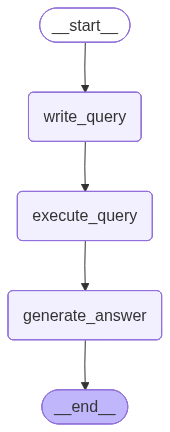

In [10]:
from typing import Annotated, TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools import QuerySQLDatabaseTool
from langgraph.graph import START, StateGraph 
from IPython.display import Image, display

# 상태 정보를 저장하는 State 클래스
class State(TypedDict):
    question: str  # 입력 질문
    query: str     # 생성된 쿼리
    result: str    # 쿼리 결과
    answer: str    # 생성된 답변

# llm 모델 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# sql 쿼리 생성 프롬프트 
template = """
Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Entity names and their relationships to consider:
{entity_info}

## Matching Guidelines
- Use exact matches when comparing entity names
- Check for historical name variations if available
- Apply case-sensitive matching for official names
- Handle both Korean and English entity names when present

Question: {input}
"""
query_prompt_template = ChatPromptTemplate.from_template(template)

# SQL 쿼리 생성 함수
class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]

def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
            "entity_info": entity_retriever_tool.invoke(state["question"]),
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

# SQL 쿼리 실행 함수
def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

# 답변 생성 함수
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}


# 상태 그래프 생성
graph_builder = StateGraph(State)

graph_builder.add_node("write_query", write_query)
graph_builder.add_node("execute_query", execute_query)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query", "execute_query")
graph_builder.add_edge("execute_query", "generate_answer")  
graph = graph_builder.compile()

# 상태 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# 고유명사를 사용하는 쿼리 테스트 - 운용사
for step in graph.stream(
    {"question": "케이비에서 운용하는 헬스케어 ETF는 무엇인가요?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT "종목코드", "종목명", "분류체계", "수익률_최근1년", "총보수" FROM ETFs WHERE "운용사" = \'케이비자산운용\' AND "분류체계" LIKE \'%헬스케어%\' LIMIT 10'}}
{'execute_query': {'result': "[('253280', 'RISE 헬스케어', '주식-업종섹터-헬스케어', 17.51, 0.4)]"}}


{'generate_answer': {'answer': "케이비자산운용에서 운용하는 헬스케어 ETF는 'RISE 헬스케어'입니다.  \n- 종목코드: 253280  \n- 분류체계: 주식-업종섹터-헬스케어  \n- 최근 1년 수익률: 17.51%  \n- 총보수: 0.4%"}}


In [12]:
# 고유명사를 사용하는 쿼리 테스트 - 기초지수, 펀드명
for step in graph.stream(
    {"question": "다우존스 관련 ETF를 찾아주세요."}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT 종목코드, 종목명, 운용사, 수익률_최근1년 FROM ETFs WHERE 종목명 LIKE '%다우존스%' ORDER BY 수익률_최근1년 DESC LIMIT 10"}}
{'execute_query': {'result': "[('245340', 'TIGER 미국다우존스30', '미래에셋자산운용', 28.87), ('446720', 'SOL 미국배당다우존스', '신한자산운용', 22.3), ('458730', 'TIGER 미국배당다우존스', '미래에셋자산운용', 22.09), ('402970', 'ACE 미국배당다우존스', '한국투자신탁운용', 21.62), ('213630', 'PLUS 미국다우존스고배당주(합성 H)', '한화자산운용', 15.74), ('458750', 'TIGER 미국배당다우존스타겟커버드콜1호', '미래에셋자산운용', 15.66), ('458760', 'TIGER 미국배당다우존스타겟커버드콜2호', '미래에셋자산운용', 9.23), ('452360', 'SOL 미국배당다우존스(H)', '신한자산운용', 7.57), ('487950', 'KODEX 대만테크고배당다우존스', '삼성자산운용', 0.0), ('489250', 'KODEX 미국배당다우존스', '삼성자산운용', 0.0)]"}}


{'generate_answer': {'answer': '다우존스와 관련된 ETF는 다음과 같습니다:\n\n1. TIGER 미국다우존스30 (미래에셋자산운용) - 최근 1년 수익률: 28.87%\n2. SOL 미국배당다우존스 (신한자산운용) - 최근 1년 수익률: 22.3%\n3. TIGER 미국배당다우존스 (미래에셋자산운용) - 최근 1년 수익률: 22.09%\n4. ACE 미국배당다우존스 (한국투자신탁운용) - 최근 1년 수익률: 21.62%\n5. PLUS 미국다우존스고배당주(합성 H) (한화자산운용) - 최근 1년 수익률: 15.74%\n6. TIGER 미국배당다우존스타겟커버드콜1호 (미래에셋자산운용) - 최근 1년 수익률: 15.66%\n7. TIGER 미국배당다우존스타겟커버드콜2호 (미래에셋자산운용) - 최근 1년 수익률: 9.23%\n8. SOL 미국배당다우존스(H) (신한자산운용) - 최근 1년 수익률: 7.57%\n9. KODEX 대만테크고배당다우존스 (삼성자산운용) - 최근 1년 수익률: 0.0%\n10. KODEX 미국배당다우존스 (삼성자산운용) - 최근 1년 수익률: 0.0%\n\n필요하신 경우 더 자세한 정보를 알려드릴 수 있습니다.'}}


## **LLM과 RAG를 결합한 추천 시스템** 

- **전통적인 추천** 시스템의 주요 문제점들:
    - **데이터 희소성** 문제로 인해 대부분의 사용자-아이템 상호작용 정보가 부족함
    - 신규 사용자나 아이템에 대한 **콜드 스타트** 현상으로 초기 추천이 어려움
    - **명시적 피드백**(평점, 리뷰)의 수집이 제한적이며 신뢰성에 한계가 있음 
    - **틈새 아이템**과 신규 콘텐츠는 충분한 상호작용 데이터 확보가 어려워 추천이 제한됨 

- **RAG 기반 추천** 시스템의 가능성:

    - **벡터 데이터베이스**와 **LLM**을 결합하여 효율적인 검색과 자연어 처리를 구현
    - **LangChain** 기반 파이프라인으로 상품 데이터의 벡터화부터 추천까지 일관된 프로세스를 구축함
    - **RAG 시스템**을 통해 컨텍스트를 고려한 개인화된 추천이 가능함
    - 전통적 추천 시스템의 한계를 **자연어 기반 추천**으로 보완하여 더 풍부한 설명을 제공 가능

### 1) **전체 시스템 개요**

- **상태 관리 시스템**이 사용자 프로필부터 추천 결과까지 체계적으로 데이터를 관리

- 각 단계별 추천 정확도를 높일 수 있도록 세분화된 **프로세스 체인**으로 역할을 구분

- **구조화된 프롬프트**를 통해 일관된 형식의 결과물을 생성

- **출력 데이터**가 JSON 형식으로 표준화되어 후속 처리에 활용 

```mermaid
flowchart LR
    Q[사용자 질문] --> P[프로필 분석]
    P -->|투자 성향 & 목표 추출| S[SQL 쿼리 생성]
    S -->|데이터베이스 조회| E[후보 ETF 검색]
    E -->|필터링 조건 적용| R[랭킹 및 필터링]
    R -->|상위 후보 선정| D[설명 생성]
    
    style Q fill:#e1f5fe,stroke:#01579b
    style P fill:#e8f5e9,stroke:#1b5e20
    style S fill:#fff3e0,stroke:#e65100
    style E fill:#f3e5f5,stroke:#4a148c
    style R fill:#fbe9e7,stroke:#bf360c
    style D fill:#e8eaf6,stroke:#1a237e

    subgraph 데이터 처리
    S
    E
    R
    end

    subgraph 출력 생성
    D
    end
```

### 2) **상태(State) 관리**

- **State** 클래스는 **TypedDict**를 상속받아 ETF 추천 시스템의 상태를 관리함
- 사용자와의 상호작용 정보를 **question**과 **user_profile**에 저장
- ETF 분석 결과는 **candidates**와 **rankings** 리스트에 보관
- 최종 출력 관련 데이터는 **explanation**과 **final_answer**에 기록

In [13]:
from typing import TypedDict

# 상태 정보를 저장하는 State 클래스
class State(TypedDict):
    question: str          # 사용자 입력 질문
    user_profile: dict     # 사용자 프로필 정보
    query: str             # 생성된 SQL 쿼리
    candidates: list       # 후보 ETF 목록
    rankings: list         # 순위가 매겨진 ETF 목록
    explanation: str       # 추천 이유 설명
    final_answer: str      # 최종 추천 답변

### 3) **프로세스 체인**

- 시스템은 **사용자 입력**으로 시작하여 **프로필 분석**을 통해 맞춤형 추천을 준비함
- **SQL 쿼리**와 **ETF 검색** 과정을 통해 데이터베이스에서 적절한 상품을 찾음
- **랭킹 시스템**을 통해 최적의 ETF를 선별하고 **맞춤형 설명**을 생성함

`(1) 사용자 프로필 분석`

- 시스템은 사용자의 **투자 성향**과 **위험 선호도**를 먼저 파악함
- **투자 목표**, **투자 기간**, **투자 가능 금액**을 종합적으로 분석
- 사용자의 **과거 투자 이력**과 **현재 포트폴리오** 구성을 검토
- 프로필 분석은 **개인화된 ETF 추천**을 위한 핵심 기초 데이터를 제공함


In [14]:
from enum import Enum
from typing import List
from pydantic import BaseModel, Field

class RiskTolerance(Enum):
    CONSERVATIVE = "conservative"
    MODERATE = "moderate" 
    AGGRESSIVE = "aggressive"

class InvestmentHorizon(Enum):
    SHORT = "short"
    MEDIUM = "medium"
    LONG = "long"

class InvestmentProfile(BaseModel):
    risk_tolerance: RiskTolerance = Field(
        description="투자자의 위험 성향 (conservative/moderate/aggressive)"
    )
    investment_horizon: InvestmentHorizon = Field(
        description="투자 기간 (short/medium/long)"
    )
    investment_goal: str = Field(
        description="투자의 주요 목적 설명"
    )
    preferred_sectors: List[str] = Field(
        description="선호하는 투자 섹터 목록"
    )
    excluded_sectors: List[str] = Field(
        description="투자를 원하지 않는 섹터 목록"
    )
    monthly_investment: int = Field(
        description="월 투자 가능 금액 (원)"
    )

In [15]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# 사용자 프로필 분석 프롬프트
PROFILE_TEMPLATE= """
사용자의 질문을 분석하여 투자 프로필을 생성해주세요.

사용자 질문: {question}
"""

profile_prompt = ChatPromptTemplate.from_template(PROFILE_TEMPLATE)

# 사용자 프로필 분석 모델 생성
llm = ChatOpenAI(model="gpt-4.1-mini")
profile_llm = llm.with_structured_output(InvestmentProfile)

# 사용자 프로필 분석 함수
def analyze_profile(state: State) -> dict:
    """사용자 질문을 분석하여 투자 프로필 생성"""
    prompt = profile_prompt.invoke({"question": state["question"]})
    response = profile_llm.invoke(prompt)
    return {"user_profile": dict(response)}


# 예시 질문 
question = """
저는 30대 초반의 직장인입니다. 
월 100만원 정도를 3년 이상 장기 투자하고 싶고,
기술 섹터와 헬스케어에 관심이 있습니다.
중위험 중수익을 추구하며, ESG 요소도 고려하고 싶습니다.
적합한 ETF를 추천해주세요.
"""

# 사용자 프로필 분석
result_profile = analyze_profile({"question": question})

# 결과 출력
result_profile

{'user_profile': {'risk_tolerance': <RiskTolerance.MODERATE: 'moderate'>,
  'investment_horizon': <InvestmentHorizon.LONG: 'long'>,
  'investment_goal': '중위험 중수익을 추구하며 ESG 요소를 고려한 장기 투자',
  'preferred_sectors': ['기술', '헬스케어'],
  'excluded_sectors': [],
  'monthly_investment': 1000000}}

`(2) ETF 검색 쿼리 프롬프트 생성`

- **사용자 프로필** {user_profile}과 **입력 질문** {input}에 따라 최적화된 쿼리 생성

In [16]:
from typing import TypedDict, Annotated
from langchain.prompts import ChatPromptTemplate

# SQL Query Generation Template
QUERY_TEMPLATE = """
Given an input question and investment profile, create a syntactically correct {dialect} query to run. Unless specified, limit your query to at most {top_k} results. Order the results by most relevant columns based on the investment profile.

Never query for all columns from a specific table, only ask for relevant columns given the question and investment criteria.

Pay attention to use only the column names you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Available tables:
{table_info}

Entity relationships:
{entity_info}

## Matching Guidelines
- Use exact matches when comparing entity names
- Check for historical name variations if available
- Apply case-sensitive matching for official names
- Handle both Korean and English entity names when present

Investment Profile:
{user_profile}

Question: {input}

## Constraints
1. Use only existing columns
2. Query only necessary columns (no SELECT *)
3. Follow correct table relationships
4. Consider performance and indexing
"""

# SQL Query Generation Prompt Template
query_prompt_template = ChatPromptTemplate.from_template(QUERY_TEMPLATE)

# SQL Query Output
class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]
    explanation: Annotated[str, ..., "Query explanation and selection criteria (in 한국어)"]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
            "entity_info": entity_retriever_tool.invoke(state["question"]),
            "user_profile": state["user_profile"],
        }
    )
    structured_llm = ChatOpenAI(model="gpt-4.1").with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"], "explanation": result["explanation"]}

# 테스트
result_query = write_query({ 
    "question": question,
    "user_profile": result_profile["user_profile"]
})

# 결과 출력
result_query


{'query': "SELECT 종목코드, 종목명, 분류체계, 운용사, 수익률_최근1년, 변동성, 총보수, 순자산총액, 과세유형\nFROM ETFs\nWHERE (\n    (분류체계 LIKE '%기술%' OR 분류체계 LIKE '%헬스케어%')\n    OR 종목명 LIKE '%헬스케어%' \n    OR 종목명 LIKE '%ESG%'\n    OR 분류체계 LIKE '%ESG%'\n)\nAND 변동성 IN ('중간', '낮음')\nORDER BY 수익률_최근1년 DESC, 순자산총액 DESC\nLIMIT 10;",
 'explanation': "기술 및 헬스케어 섹터에 집중하고, 중위험(변동성 '중간' 또는 '낮음') ETF를 찾으면서 ESG 관련 키워드도 포함했습니다. 수익률과 순자산총액 기준으로 높은 순서로 정렬하여 장기투자와 안정성을 고려했습니다."}

`(3) ETF 검색 쿼리 실행`

In [17]:
from langchain_community.tools import QuerySQLDatabaseTool

def execute_query(state: State) -> dict:
    """SQL 쿼리 실행하여 후보 ETF 검색"""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    results = execute_query_tool.invoke(state["query"])
    return {"candidates": results}

# 테스트
result_candidates = execute_query({
    "query": result_query["query"]
})

# 결과 출력
result_candidates

{'candidates': "[('399110', 'SOL 미국S&P500ESG', '주식-시장대표', '신한자산운용', 41.18, '낮음', 0.15, 63153292182.0, '배당소득세(보유기간과세)'), ('453640', 'KODEX 미국S&P500헬스케어', '주식-업종섹터-헬스케어', '삼성자산운용', 14.18, '낮음', 0.25, 23758942450.0, '배당소득세(보유기간과세)'), ('248270', 'TIGER S&P글로벌헬스케어(합성)', '주식-업종섹터-헬스케어', '미래에셋자산운용', 12.54, '낮음', 0.4, 37862044072.0, '배당소득세(보유기간과세)'), ('253290', 'RISE 헬스케어채권혼합', '혼합자산-주식+채권', '케이비자산운용', 7.27, '낮음', 0.35, 14338485899.0, '배당소득세(보유기간과세)')]"}

In [18]:
for candidate in eval(result_candidates["candidates"]):
    print(candidate)

('399110', 'SOL 미국S&P500ESG', '주식-시장대표', '신한자산운용', 41.18, '낮음', 0.15, 63153292182.0, '배당소득세(보유기간과세)')
('453640', 'KODEX 미국S&P500헬스케어', '주식-업종섹터-헬스케어', '삼성자산운용', 14.18, '낮음', 0.25, 23758942450.0, '배당소득세(보유기간과세)')
('248270', 'TIGER S&P글로벌헬스케어(합성)', '주식-업종섹터-헬스케어', '미래에셋자산운용', 12.54, '낮음', 0.4, 37862044072.0, '배당소득세(보유기간과세)')
('253290', 'RISE 헬스케어채권혼합', '혼합자산-주식+채권', '케이비자산운용', 7.27, '낮음', 0.35, 14338485899.0, '배당소득세(보유기간과세)')


`(4) 후보 ETF 랭킹 및 필터링`

- **랭킹 시스템**은 **수익률**, **순자산총액**, **총보수**, **변동성** 등 5가지 핵심 지표를 평가함
- 순위 결정에는 **사용자 프로필** {user_profile}과 **후보 ETF** {candidates} 정보가 활용됨
- 각 ETF는 **점수화**되어 상위 3개가 출력됨

In [19]:
from typing import TypedDict, Annotated
from langchain.prompts import ChatPromptTemplate

RANKING_TEMPLATE = """
Rank the following ETF candidates based on the user's investment profile and return the top 3(three) ETFs.
Consider these factors when ranking:

1. 수익률
2. 변동성
3. 순자산총액
4. 총보수
5. User Profile matching score

User Profile:
{user_profile}

Candidate ETFs:
{candidates}

Table Info:
(table_info)
"""

# ETF Ranking Prompt Template
ranking_prompt = ChatPromptTemplate.from_template(RANKING_TEMPLATE)


# ETF Ranking Output
class ETFRanking(TypedDict):
    """Individual ETF ranking result"""
    rank: Annotated[int, ..., "Ranking position (1-5)"]
    etf_code: Annotated[str, ..., "ETF 종목코드 (6-digit)"]
    etf_name: Annotated[str, ..., "ETF 종목명"]
    score: Annotated[float, ..., "Composite score (0-100)"]
    ranking_reason: Annotated[str, ..., "Explanation for the ranking (in 한국어)"]

class ETFRankingResult(TypedDict):
    """Ranked ETFs"""
    rankings: List[ETFRanking]

# ETF Ranking Function
def rank_etfs(state: State) -> dict:
    """Rank ETF candidates based on user's investment profile"""
    prompt = ranking_prompt.invoke(
        {
            "user_profile": state["user_profile"],
            "candidates": state["candidates"],
            "table_info": db.get_table_info(),
        }
    )
    structured_llm = ChatOpenAI(model="gpt-4.1").with_structured_output(ETFRankingResult)
    results = structured_llm.invoke(prompt)

    return {"rankings": results}

# 테스트
result_rankings = rank_etfs({
    "user_profile": result_profile["user_profile"],
    "candidates": result_candidates["candidates"]
})  # type: ignore

# 결과 출력
result_rankings

{'rankings': {'rankings': [{'rank': 1,
    'etf_code': '399110',
    'etf_name': 'SOL 미국S&P500ESG',
    'score': 95,
    'ranking_reason': 'ESG 요인을 고려하면서도 S&P500 지수를 추종하는 ETF로, 수익률이 매우 높고(41.18%), 변동성이 낮으며, 순자산총액이 6315억원 이상으로 안정적입니다. 중위험 중수익 장기투자자에게 매우 적합하며, 총보수도 0.15%로 저렴해 투자 매력이 큽니다. 기술 섹터도 일부 포함된다는 점에서 사용자 프로필과 가장 잘 부합합니다.'},
   {'rank': 2,
    'etf_code': '453640',
    'etf_name': 'KODEX 미국S&P500헬스케어',
    'score': 83,
    'ranking_reason': '사용자 선호 섹터인 헬스케어를 집중적으로 담고 있고, 수익률(14.18%)도 양호하며 변동성도 낮습니다. 순자산총액(2375억원)도 나쁘지 않고, 총보수(0.25%)도 적당합니다. 장기투자 관점과 헬스케어 선호에 매우 잘 맞는 ETF입니다.'},
   {'rank': 3,
    'etf_code': '248270',
    'etf_name': 'TIGER S&P글로벌헬스케어(합성)',
    'score': 77,
    'ranking_reason': '헬스케어 섹터에 투자하며, 수익률(12.54%)과 낮은 변동성, 0.4%의 보수 모두 무난합니다. 순자산총액이 3786억원으로 안정적이며, 사용자 프로필의 장기·헬스케어 선호와 부합합니다. 상위 후보들에 비해 보수가 다소 높은 점이 있지만 투자매력은 충분합니다.'}]}}

`(5) 추천 설명 생성`

- ETF 설명은 **주요 특징{rankings}** 과 **사용자 적합성{user_profile}** 을 중심으로 구성
- **포트폴리오 구성안**을 제시하여 **실용적이고 이해하기 쉬운** 실질적인 투자 가이드를 제공
- **리스크 요소**와 **주의사항**을 명확히 설명하여 투자자 보호를 강화

In [20]:
from typing import List
from pydantic import BaseModel, Field
from decimal import Decimal
from langchain.prompts import ChatPromptTemplate

EXPLANATION_TEMPLATE = """
Please provide a comprehensive explanation for the recommended ETFs based on the user's investment profile.


[RECOMMENDATION EXPLANATION (Examples)]
1. ETF Characteristics
   - Investment strategy and approach
   - Historical performance overview
   - Fee structure and efficiency
   - Underlying assets and diversification

2. Profile Fit Analysis
   - Alignment with risk tolerance
   - Match with investment horizon
   - Sector preference compatibility
   - Investment goal contribution

3. Portfolio Construction
   - Recommended allocation percentages
   - Diversification benefits
   - Rebalancing considerations
   - Implementation strategy

4. Risk Considerations
   - Market risk factors
   - Specific ETF risks
   - Economic scenario impacts
   - Monitoring requirements

--------------------------------------------

[User Profile]
{user_profile}

[Selected ETFs]
{rankings}
"""

# 추천 설명 프롬프트
explanation_prompt = ChatPromptTemplate.from_template(EXPLANATION_TEMPLATE)


# 추천 설명 출력 스키마
class ETFRecommendation(BaseModel):
   """Individual ETF recommendation details"""
   etf_code: str = Field(..., description="ETF 종목코드 (6-digit)")
   etf_name: str = Field(..., description="ETF 종목명")
   allocation: Decimal = Field(..., description="Recommended allocation % (0-100)")
   description: str = Field(..., description="ETF description and investment strategy (in 한국어)")
   key_points: List[str] = Field(..., description="Key investment points (in 한국어)")
   risks: List[str] = Field(..., description="Risk factors to consider (in 한국어)")

class RecommendationExplanation(BaseModel):
   """ETF recommendation explanation with markdown formatting"""
   overview: str = Field(..., description="Overall strategy explanation (in 한국어)")
   recommendations: List[ETFRecommendation] = Field(..., description="ETF details")
   considerations: List[str] = Field(..., description="Important considerations (in 한국어)")
   
   # 마크다운 포맷으로 출력
   def to_markdown(self) -> str:
      """Convert explanation to markdown format"""
      markdown = [
            "# ETF 포트폴리오 추천",
            "",
            "## 투자 전략 개요",
            self.overview,
            "",
            "## 추천 ETF 포트폴리오",
            ""
      ]
      
      # 포트폴리오 구성 비율
      markdown.extend([
            "| ETF | 종목코드 | 추천비중 |",
            "|-----|----------|----------|"
      ])
      
      for rec in self.recommendations:
         markdown.append(
            f"| {rec.etf_name} | {rec.etf_code} | {rec.allocation}% |"
            )
      
      # ETF 상세 설명
      markdown.append("\n## ETF 상세 설명\n")
      
      for rec in self.recommendations:
         markdown.extend([
               f"### {rec.etf_name} ({rec.etf_code})",
               rec.description,
               "",
               "**주요 투자 포인트:**",
               "".join([f"\n* {point}" for point in rec.key_points]),
               "",
               "**투자 위험:**",
            "".join([f"\n* {risk}" for risk in rec.risks]),
         ""
         ])
      
      # 투자 리스크 고려사항
      markdown.extend([
            "## 투자 시 고려사항",
            "".join([f"\n* {item}" for item in self.considerations]),
            ""
      ])
      
      return "\n".join(markdown)
   

# 추천 설명 생성 함수
def generate_explanation(state: dict) -> dict:
   """Generate structured ETF recommendation explanation"""
   # 프롬프트 생성
   prompt = explanation_prompt.invoke({
      "rankings": state["rankings"],
      "user_profile": state["user_profile"]
   })
   
   # 구조화된 출력 생성
   structured_llm = ChatOpenAI(model="gpt-4.1-mini").with_structured_output(RecommendationExplanation)
   response = structured_llm.invoke(prompt)

   return {"final_answer": {
      "explanation": response.model_dump(), 
      "markdown": response.to_markdown()
   }}
   

# 테스트
result_explanation = generate_explanation({
   "rankings": result_rankings["rankings"],
   "user_profile": result_profile["user_profile"]
})

In [21]:
# 결과 출력
result_explanation["final_answer"]["explanation"]

{'overview': '사용자는 중위험 중수익을 추구하며 ESG 요소를 고려한 장기 투자를 원하고, 기술과 헬스케어 섹터에 관심이 많습니다. 이에 따라 추천된 ETF들은 이러한 투자 성향과 목표에 부합하도록 선정되었으며, 각각의 특성과 리스크를 이해하고 적절히 분산 투자하는 전략을 제안합니다.',
 'recommendations': [{'etf_code': '399110',
   'etf_name': 'SOL 미국S&P500ESG',
   'allocation': Decimal('60'),
   'description': '이 ETF는 S&P500 지수를 기반으로 하면서 ESG(환경, 사회, 지배구조) 요소를 반영한 기업에 투자합니다. 높은 수익률(41.18%)과 낮은 변동성을 보이며, 기술 섹터를 포함해 다양한 산업에 분산되어 있습니다. 총보수율이 0.15%로 매우 저렴하여 장기 투자에서 비용 부담이 적습니다.',
   'key_points': ['S&P500 ESG 지수를 추종하여 대형 우량주에 분산 투자',
    '기술 섹터 일부 포함, 사용자의 선호와 부합',
    '낮은 총보수(0.15%)로 비용 효율적',
    '순자산총액 6315억원 이상으로 유동성 및 안정성 확보'],
   'risks': ['미국 주식시장 전반의 변동성에 영향 받음',
    'ESG 기준 변화 및 평가 방식에 따른 투자 대상 변화 가능성',
    '중장기 시장 상황에 따라 수익률 변동 가능성']},
  {'etf_code': '453640',
   'etf_name': 'KODEX 미국S&P500헬스케어',
   'allocation': Decimal('25'),
   'description': '헬스케어 섹터에 집중 투자하는 ETF로, 수익률 14.18%와 낮은 변동성을 기록하고 있습니다. 사용자의 헬스케어 선호에 부합하며, 중위험 중수익 장기투자에 적합한 구성입니다. 총보수도 0.25%로 적당하여 비용도 합리적입니다.',
   'key_points': ['미국 헬

In [22]:
# 마크다운 출력
from IPython.display import Markdown
Markdown(result_explanation["final_answer"]["markdown"])

# ETF 포트폴리오 추천

## 투자 전략 개요
사용자는 중위험 중수익을 추구하며 ESG 요소를 고려한 장기 투자를 원하고, 기술과 헬스케어 섹터에 관심이 많습니다. 이에 따라 추천된 ETF들은 이러한 투자 성향과 목표에 부합하도록 선정되었으며, 각각의 특성과 리스크를 이해하고 적절히 분산 투자하는 전략을 제안합니다.

## 추천 ETF 포트폴리오

| ETF | 종목코드 | 추천비중 |
|-----|----------|----------|
| SOL 미국S&P500ESG | 399110 | 60% |
| KODEX 미국S&P500헬스케어 | 453640 | 25% |
| TIGER S&P글로벌헬스케어(합성) | 248270 | 15% |

## ETF 상세 설명

### SOL 미국S&P500ESG (399110)
이 ETF는 S&P500 지수를 기반으로 하면서 ESG(환경, 사회, 지배구조) 요소를 반영한 기업에 투자합니다. 높은 수익률(41.18%)과 낮은 변동성을 보이며, 기술 섹터를 포함해 다양한 산업에 분산되어 있습니다. 총보수율이 0.15%로 매우 저렴하여 장기 투자에서 비용 부담이 적습니다.

**주요 투자 포인트:**

* S&P500 ESG 지수를 추종하여 대형 우량주에 분산 투자
* 기술 섹터 일부 포함, 사용자의 선호와 부합
* 낮은 총보수(0.15%)로 비용 효율적
* 순자산총액 6315억원 이상으로 유동성 및 안정성 확보

**투자 위험:**

* 미국 주식시장 전반의 변동성에 영향 받음
* ESG 기준 변화 및 평가 방식에 따른 투자 대상 변화 가능성
* 중장기 시장 상황에 따라 수익률 변동 가능성

### KODEX 미국S&P500헬스케어 (453640)
헬스케어 섹터에 집중 투자하는 ETF로, 수익률 14.18%와 낮은 변동성을 기록하고 있습니다. 사용자의 헬스케어 선호에 부합하며, 중위험 중수익 장기투자에 적합한 구성입니다. 총보수도 0.25%로 적당하여 비용도 합리적입니다.

**주요 투자 포인트:**

* 미국 헬스케어 섹터 집중 투자
* 낮은 변동성과 안정적 수익률 제공
* 순자산총액 2375억원으로 안정성 확보
* 중장기 관점에서 헬스케어 산업 성장에 투자 가능

**투자 위험:**

* 헬스케어 섹터 특화에 따른 섹터 리스크
* 규제 변화에 민감할 수 있음
* 개별기업 성과에 따른 수익률 변동 가능성

### TIGER S&P글로벌헬스케어(합성) (248270)
글로벌 헬스케어 기업에 투자하는 합성 ETF로, 수익률 12.54%와 적당한 변동성을 보입니다. 순자산총액 3786억원으로 안정적이며, 총보수 0.4% 수준이지만 글로벌 분산 효과와 헬스케어 선호에 부합하는 투자입니다.

**주요 투자 포인트:**

* 글로벌 헬스케어 기업에 분산 투자
* 안정적인 순자산총액과 수익률 유지
* 합성 인덱스 펀드로 환헤지 및 운용 효율성 제공
* 장기 투자에 적합한 헬스케어 집중 전략

**투자 위험:**

* 합성 ETF 특성상 파생상품 관련 위험 존재
* 글로벌 경제 및 헬스케어 규제 리스크
* 총보수가 상대적으로 높아 비용 부담 증가 가능성

## 투자 시 고려사항

* 추천 비중은 사용자의 중위험 중수익 목표를 반영한 분산 구성임
* 장기 투자 관점에서 각 ETF의 지속가능한 성장성과 비용 효율성을 고려함
* 헬스케어 섹터 집중에 따른 섹터 리스크도 분산 투자로 일부 완화 가능
* 시장 변동성과 경제 상황 변화에 따른 정기적인 포트폴리오 점검과 리밸런싱 권장


`(6) 상태 그래프 생성`

- 전체 프로세스 체인을 연결하여 상태 그래프를 생성

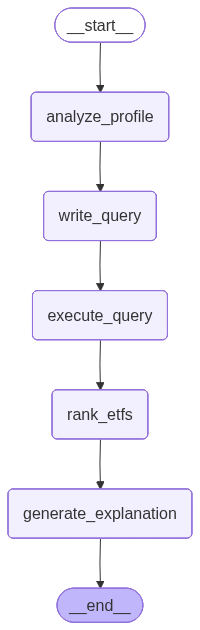

In [23]:
from langgraph.graph import StateGraph, START, END

# 상태 그래프 생성
graph_builder = StateGraph(State)

graph_builder.add_node("analyze_profile", analyze_profile)
graph_builder.add_node("write_query", write_query)
graph_builder.add_node("execute_query", execute_query)
graph_builder.add_node("rank_etfs", rank_etfs)
graph_builder.add_node("generate_explanation", generate_explanation)

graph_builder.add_edge(START, "analyze_profile")
graph_builder.add_edge("analyze_profile", "write_query")
graph_builder.add_edge("write_query", "execute_query")
graph_builder.add_edge("execute_query", "rank_etfs")
graph_builder.add_edge("rank_etfs", "generate_explanation")
graph_builder.add_edge("generate_explanation", END)

graph = graph_builder.compile()


# 상태 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
# 사용자 질문 예시

test_qeustions = [
    """
    40대 중반의 직장인입니다. 
    월 200만원 정도를 1년 이상 장기 투자하고 싶고,
    환율과 금리에 관심이 있습니다.
    저위험 안정적인 수익을 추구하며, ESG 요소도 고려하고 싶습니다.
    적합한 ETF를 추천해주세요.
    """,
    """
    20대 후반의 대학생입니다. 
    월 50만원 정도를 1년 이상 장기 투자하고 싶고,
    환율과 금리에 관심이 있습니다.
    고위험 고수익을 추구하며, ESG 요소도 고려하고 싶습니다.
    적합한 ETF를 추천해주세요.
    """,
    """
    32살 맞벌이 부부입니다. 
    둘이 합쳐서 월 200만원을 노후자금으로 굴리고 싶어요. 
    제약/바이오와 클라우드 컴퓨팅 쪽을 보고 있습니다. 
    안정성과 수익성의 균형을 맞추고 싶고, 
    지속가능한 기업들 위주로 투자하고 싶습니다.
    적합한 ETF를 추천해주세요.
    """
]


# 상태 그래프 실행
etf_recommendations = []
for question in test_qeustions:
    etf_recommendation = graph.invoke(
        {"question": question}
    )
    etf_recommendations.append(etf_recommendation)

In [25]:
# 결과 출력
Markdown(etf_recommendations[0]["final_answer"]["markdown"])

# ETF 포트폴리오 추천

## 투자 전략 개요
사용자는 저위험 안정적인 수익을 추구하며 환율과 금리 변동에 노출되는 동시에 ESG 요소를 고려한 장기 투자를 희망합니다. 이에 따라, 안정적이면서도 환율 헤지 효과가 있는 채권형 ETF를 중심으로 구성하였으며, ESG 기준을 엄격히 적용한 자산에 투자하는 상품 위주로 선별하였습니다. 보수적 성향과 장기 투자 목적에 부합하는 낮은 변동성과 합리적인 수수료 구조의 ETF를 권장합니다.

## 추천 ETF 포트폴리오

| ETF | 종목코드 | 추천비중 |
|-----|----------|----------|
| KODEX 아시아달러채권ESG플러스액티브 | 삼성자산운용-1 | 50% |
| KODEX ESG종합채권(A-이상)액티브 | 삼성자산운용-2 | 35% |
| 히어로즈 단기채권ESG액티브 | 키움투자자산운용-1 | 15% |

## ETF 상세 설명

### KODEX 아시아달러채권ESG플러스액티브 (삼성자산운용-1)
이 ETF는 아시아 달러표시 중기 혼합채권에 투자하며 ESG 평가가 우수한 자산을 포함합니다. 환율 노출과 금리 변화에 대한 자연스러운 헷지가 가능하며, 낮은 변동성으로 보수적 투자자에게 적합합니다.

**주요 투자 포인트:**

* 환율 관련 자산 포함으로 환헤지 효과 기대
* ESG 요소 엄격 반영으로 지속가능성 확보
* 중기 혼합채권 중심으로 안정적 수익 추구
* 총보수 0.18%로 비용 효율적

**투자 위험:**

* 채권시장 금리 변동 위험
* 환율 변동 위험 존재
* 아시아 시장 국가별 신용 위험

### KODEX ESG종합채권(A-이상)액티브 (삼성자산운용-2)
우량 채권(A-등급 이상)에 투자하는 ESG채권 종합 ETF로, 높은 신용등급으로 인해 안정성과 신뢰성이 높습니다. 수수료가 매우 저렴하여 장기 보유에 유리하며, 낮은 변동성으로 저위험 성향에 적합합니다.

**주요 투자 포인트:**

* 우량 채권 중심으로 신용 위험 최소화
* ESG 평가가 우수한 채권 비중 확대
* 총보수 0.07%로 장기 투자 적합
* 안정적 수익률과 낮은 변동성 제공

**투자 위험:**

* 금리 상승 시 가격 하락 가능성
* 신용등급 하락에 따른 위험
* 시장 유동성 위험

### 히어로즈 단기채권ESG액티브 (키움투자자산운용-1)
단기채권에 투자하며 ESG 요인을 반영한 ETF로 변동성이 매우 낮아 보수적인 투자자가 포트폴리오 내 일정 비중 보유 시 위험 분산에 효과적입니다. 장기 투자 시 현금성 자산의 대체 수단으로도 활용 가능하며, 적정 수익을 제공합니다.

**주요 투자 포인트:**

* 단기채권 투자로 금리 변동 영향 제한
* ESG 기준 반영 자산으로 지속가능성 강조
* 총보수 0.15%로 비용 적정
* 낮은 변동성으로 안정적 배분에 용이

**투자 위험:**

* 초단기 금리 변동 영향 존재
* 환율 변동성 낮으나 일부 통화 위험 존재
* 단기 채권 특성상 수익률 다소 제한적

## 투자 시 고려사항

* 본 포트폴리오는 저위험·안정적인 수익을 위한 채권 중심으로 구성되었으며, 환율 변동과 금리 영향을 분산하는 효과가 있습니다.
* ESG 필터링을 통한 지속가능 투자로 장기적 리스크 완화 및 긍정적 사회적 영향 기대할 수 있습니다.
* 각 ETF의 운용보수 및 시장 변동성을 고려해 주기적인 재조정을 권장합니다.
* 시장 금리 상승기에는 채권 가격 하락 리스크가 있으므로 모니터링이 필요합니다.
* 장기 투자 성격을 감안해 단기 변동성에 일희일비하지 않고 꾸준히 투자하는 것이 중요합니다.


In [26]:
# 결과 출력
Markdown(etf_recommendations[1]["final_answer"]["markdown"])

# ETF 포트폴리오 추천

## 투자 전략 개요
고위험 고수익을 추구하며 ESG 요소를 중시하는 장기 투자자에게 맞춘 ETF 포트폴리오를 구성하였습니다. 세 가지 ETF는 모두 ESG 테마를 기반으로 하며, 각기 다른 투자 전략과 수수료 구조, 그리고 규모를 갖춰 포트폴리오의 다각화 및 안정적인 성장 기회를 제공합니다. 사용자의 공격적인 투자 성향과 장기 투자 목표에 부합하도록 수익률과 변동성을 균형 있게 고려한 구성입니다.

## 추천 ETF 포트폴리오

| ETF | 종목코드 | 추천비중 |
|-----|----------|----------|
| RISE ESG사회책임투자 | 290130 | 40% |
| KODEX 200ESG | 337160 | 35% |
| FOCUS ESG리더스 | 285690 | 25% |

## ETF 상세 설명

### RISE ESG사회책임투자 (290130)
이 ETF는 높은 연 수익률(10.58%)과 '높음' 등급 규모를 자랑하며, ESG 관련 우량 기업에 집중 투자합니다. 0.3%의 상대적으로 합리적인 보수율을 유지하며, 높은 성장 잠재력과 장기적 수익 기회를 제공합니다.

**주요 투자 포인트:**

* 가장 높은 최근 연 수익률(10.58%) 기록
* ESG 관련 우량 기업 중심 투자
* 규모가 크고 안정적인 운용
* 적정한 운용보수(0.3%)

**투자 위험:**

* 고수익 추구로 인한 높은 변동성 가능성
* ESG 테마 기업 특유의 시장 변동성 영향

### KODEX 200ESG (337160)
KODEX 200ESG ETF는 비교적 낮은 총보수율(0.09%)과 안정적인 순자산 규모를 가진 ETF로, ESG 테마를 반영한 KOSPI 200 지수를 추종합니다. 수익률과 변동성 측면에서 우수하며 장기 투자 적합합니다.

**주요 투자 포인트:**

* 낮은 총보수율(0.09%)로 비용효율성 우수
* KOSPI 200 ESG 기업 중점 편입
* 순자산 규모 크고 변동성 낮음
* 장기 보유에 적합

**투자 위험:**

* 시장 변동성에 따른 가치 변동
* ESG 평가 변화에 따른 포트폴리오 변동 가능성

### FOCUS ESG리더스 (285690)
FOCUS ESG리더스는 저보수(0.1%) ETF이며, ESG 리더 기업들을 대상으로 투자합니다. 순자산 규모는 상위 두 ETF 대비 다소 작으나, 공격적 투자자에게 적합한 성장 잠재력을 갖고 있습니다.

**주요 투자 포인트:**

* 저보수(0.1%) ETF
* ESG 리더 기업 중심 투자
* 수익률 4.28%로 준수
* 작지만 성장 가능성 있는 순자산 규모

**투자 위험:**

* 규모가 다소 작아 유동성 위험 존재
* 공격적 전략으로 변동성 큼

## 투자 시 고려사항

* 사용자의 고위험 성향에 따라 변동성이 큰 자산이 포함되어 있으며, 단기적 손실 가능성도 존재합니다.
* ESG 테마에 집중함으로써 특정 산업 및 정책 변화에 따른 리스크가 존재합니다.
* 투자 포트폴리오의 균형을 위해 정기적 리밸런싱이 필요합니다.
* 월 50만원의 투자금을 분산 투자함으로써 장기적 복리 효과를 기대할 수 있습니다.


In [27]:
# 결과 출력
Markdown(etf_recommendations[2]["final_answer"]["markdown"])

# ETF 포트폴리오 추천

## 투자 전략 개요
사용자는 중위험(Moderate) 투자성향과 장기 투자 목표를 보유하고 있으며, 노후자금 마련이라는 투자 목표에 맞춰 안정성과 수익성의 균형을 중시합니다. 또한 제약/바이오 및 클라우드 컴퓨팅 섹터를 선호하여 이와 부합하는 ETF를 추천하는 것이 효과적입니다. 이에 따라 바이오 섹터 중심의 ETF들을 선별하여 투자 포트폴리오를 구성하는 전략을 제안합니다.

## 추천 ETF 포트폴리오

| ETF | 종목코드 | 추천비중 |
|-----|----------|----------|
| TIGER 미국나스닥바이오 | 203780 | 60% |
| KOSEF 미국블록버스터바이오테크의약품+ | 483030 | 30% |
| TIMEFOLIO 글로벌안티에이징바이오액티브 | 485810 | 10% |

## ETF 상세 설명

### TIGER 미국나스닥바이오 (203780)
미국 나스닥 바이오 섹터에 집중 투자하는 ETF로, 제약 및 바이오 산업의 성장 잠재력을 활용합니다. 최근 16.47%의 높은 수익률을 기록하였으며, 변동성은 '보통'으로 중위험 투자자에게 적합합니다. 총보수 0.3%로 비용 부담도 크지 않아 장기 투자에 유리합니다.

**주요 투자 포인트:**

* 제약/바이오 섹터에 직접 투자하여 성장성 확보
* 중위험 변동성으로 안정적 수익 추구 가능
* 적정한 비용 구조로 장기 투자 적합

**투자 위험:**

* 바이오 산업 특유의 기술 및 정책 변화 리스크
* 시장 변동성에 따른 가격 등락 가능성
* 특정 산업 편중으로 인한 포트폴리오 리스크

### KOSEF 미국블록버스터바이오테크의약품+ (483030)
미국 바이오테크 및 제약 섹터에 투자하는 ETF로, 변동성이 낮아 안정적인 투자 환경을 제공합니다. 최근 수익률은 다소 저조하지만, 보수 0.49%로 적당하며 안정성을 중시하는 투자자에게 적합합니다.

**주요 투자 포인트:**

* 낮은 변동성으로 안정적 투자 가능
* 바이오테크 섹터의 지속 성장 잠재력 보유
* 다양한 블록버스터 의약품 관련 기업 포함

**투자 위험:**

* 수익률 변동성 및 산업 규제 영향
* 업계 특유의 임상시험 실패 리스크
* 상대적으로 높은 보수 부담

### TIMEFOLIO 글로벌안티에이징바이오액티브 (485810)
안티에이징 바이오 테마에 투자하는 액티브 ETF로 장기 성장 가능성이 있지만, 최근 수익률이 낮고 총보수 0.8%로 비용 부담이 가장 큰 편입니다. 변동성은 보통 수준으로 중위험 투자자에게는 신중한 접근이 필요합니다.

**주요 투자 포인트:**

* 안티에이징 바이오 분야의 성장테마 집중 투자
* 액티브 운용으로 시장 대비 초과수익 추구 가능
* 중위험 변동성에 적합

**투자 위험:**

* 높은 총보수에 따른 수익률 희석 가능성
* 액티브 운용 리스크 및 성과 변동성
* 테마 집중에 따른 산업 및 시장 변동성 영향

## 투자 시 고려사항

* 중위험 투자성향에 맞춰 변동성이 너무 높은 ETF는 비중을 제한할 것
* 장기 투자 목표에 적합하도록 성장성과 안정성 균형 중시
* 제약/바이오 섹터 선호도를 최대한 반영하되, 포트폴리오 다변화 유지 필요
* ETF 운용 보수 및 비용 구조를 확인하여 장기 수익률에 미치는 영향 점검
* 시장 상황 변화에 따른 리밸런싱 시점과 비중 조절 고려 필요


---

## **Gradio 인터페이스 구현 및 Hugging Face Spaces 배포** 

#### 1. **사전 준비**
- [Hugging Face](https://huggingface.co/spaces) 계정 생성이 필요 (무료)
- 로컬에서 작동하는 Gradio 앱을 준비
- 새로운 **가상 환경**에서 실행 (crwal4ai 의존성과 gradio 최신 버전 문제)
- **app.py** 파일을 생성하여 프로젝트 폴더로 복사 (etf_database.db 파일, .env 파일도 함께 복사)

- pyproject.toml

- 터미널에서 다음 명령어 실행

- 서버 종료: 터미널에서 Ctrl + C

- requirements.txt 파일 생성 

- .gitignore 파일 생성

#### 2. **배포 방법 (터미널 이용)**
- Gradio 앱이 있는 디렉토리로 이동 

- 터미널에서 다음 명령어 실행

- CLI가 안내하는 대로 기본 메타데이터 입력
   - HF Token : Hugging Face 계정의 Access Token 복사해서 붙여넣고 엔터 
   - git credential 설정 (y/n) : n
   - Space 이름
   - Any Spaces secrets (y/n) : env 환경변수 설정 (OPENAI_API_KEY 붙여 넣고 엔터)
   - 또는 HF Spaces Secrets에 직접 추가 (OPENAI_API_KEY 값 입력 후 엔터)

- 배포 완료 후 제공되는 URL로 접근 가능

---

## [실습] **ETF 추천 시스템 구현**

- 이전 코드를 참조하여, ETF 추천 시스템을 개선합니다. 
- Text2SQL, 프롬프트 개선, 프로세스 체인 추가 등을 통해 성능을 향상시킵니다.

In [28]:
# [실습] ETF 추천 시스템 개선 구현

# 1. 개선된 쿼리 생성 함수 (추가 필터링 조건 포함)
IMPROVED_QUERY_TEMPLATE = """
Given an input question and investment profile, create a syntactically correct {dialect} query.
Limit results to {top_k} and apply the following optimization criteria:

FILTERING CRITERIA:
1. 순자산총액 >= 100억원 (minimum asset size for liquidity)
2. 총보수 <= 0.5% (cost efficiency threshold)
3. Exclude ETFs with extreme volatility unless user specifically requests high-risk

RANKING PRIORITY:
1. Match user's preferred sectors
2. Align with risk tolerance
3. Consider investment horizon
4. Optimize for cost efficiency

Available tables:
{table_info}

Entity relationships:
{entity_info}

Investment Profile:
{user_profile}

Question: {input}

Generate a query that:
- Filters by minimum asset size and maximum fees
- Prioritizes sector alignment
- Considers risk-adjusted returns
- Orders by relevance to user profile
"""

improved_query_prompt = ChatPromptTemplate.from_template(IMPROVED_QUERY_TEMPLATE)


# 2. 개선된 쿼리 생성 함수
def improved_write_query(state: State):
    """Generate optimized SQL query with enhanced filtering"""
    prompt = improved_query_prompt.invoke({
        "dialect": db.dialect,
        "top_k": 15,  # 더 많은 후보 검색
        "table_info": db.get_table_info(),
        "input": state["question"],
        "entity_info": entity_retriever_tool.invoke(state["question"]),
        "user_profile": state["user_profile"],
    })
    structured_llm = ChatOpenAI(model="gpt-4o-mini").with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"], "explanation": result["explanation"]}


# 3. 개선된 랭킹 시스템 (가중치 기반 점수 계산)
IMPROVED_RANKING_TEMPLATE = """
Rank ETF candidates using a weighted scoring system:

SCORING WEIGHTS:
- Sector Match: 30%
- Risk Alignment: 25%
- Cost Efficiency: 20%
- Performance: 15%
- Asset Size: 10%

EVALUATION CRITERIA:
1. Sector Match: 
   - Perfect match (preferred sectors): 100 points
   - Related sectors: 50 points
   - Neutral: 25 points
   - Excluded sectors: 0 points

2. Risk Alignment:
   - Conservative: Low volatility, stable returns
   - Moderate: Balanced risk-return
   - Aggressive: High growth potential

3. Cost Efficiency:
   - Lower fees = higher score
   - Consider tracking error

4. Performance:
   - Historical returns adjusted for risk
   - Consistency over time

5. Asset Size:
   - Liquidity consideration
   - Market stability

Return TOP 3 ETFs with detailed scoring breakdown.

User Profile:
{user_profile}

Candidate ETFs:
{candidates}

Table Info:
{table_info}
"""

improved_ranking_prompt = ChatPromptTemplate.from_template(IMPROVED_RANKING_TEMPLATE)


# 4. 개선된 랭킹 함수
class ImprovedETFRanking(TypedDict):
    """Enhanced ETF ranking with detailed scoring"""
    rank: Annotated[int, ..., "Ranking position (1-3)"]
    etf_code: Annotated[str, ..., "ETF 종목코드"]
    etf_name: Annotated[str, ..., "ETF 종목명"]
    total_score: Annotated[float, ..., "Total weighted score (0-100)"]
    sector_score: Annotated[float, ..., "Sector alignment score"]
    risk_score: Annotated[float, ..., "Risk alignment score"]
    cost_score: Annotated[float, ..., "Cost efficiency score"]
    performance_score: Annotated[float, ..., "Performance score"]
    ranking_reason: Annotated[str, ..., "Detailed ranking explanation (in 한국어)"]

class ImprovedRankingResult(TypedDict):
    """Improved ranking result"""
    rankings: List[ImprovedETFRanking]


def improved_rank_etfs(state: State) -> dict:
    """Rank ETFs using weighted scoring system"""
    prompt = improved_ranking_prompt.invoke({
        "user_profile": state["user_profile"],
        "candidates": state["candidates"],
        "table_info": db.get_table_info(),
    })
    structured_llm = ChatOpenAI(model="gpt-4o-mini").with_structured_output(ImprovedRankingResult)
    results = structured_llm.invoke(prompt)
    return {"rankings": results}


# 5. 개선된 상태 그래프 구축
improved_graph_builder = StateGraph(State)

improved_graph_builder.add_node("analyze_profile", analyze_profile)
improved_graph_builder.add_node("write_query", improved_write_query)
improved_graph_builder.add_node("execute_query", execute_query)
improved_graph_builder.add_node("rank_etfs", improved_rank_etfs)
improved_graph_builder.add_node("generate_explanation", generate_explanation)

improved_graph_builder.add_edge(START, "analyze_profile")
improved_graph_builder.add_edge("analyze_profile", "write_query")
improved_graph_builder.add_edge("write_query", "execute_query")
improved_graph_builder.add_edge("execute_query", "rank_etfs")
improved_graph_builder.add_edge("rank_etfs", "generate_explanation")
improved_graph_builder.add_edge("generate_explanation", END)

improved_graph = improved_graph_builder.compile()


# 6. 개선된 시스템 테스트
print("=" * 60)
print("개선된 ETF 추천 시스템 테스트")
print("=" * 60)

test_question = """
35세 IT 업계 종사자입니다.
월 150만원을 5년 이상 장기 투자할 계획이며,
반도체와 AI 관련 기술주에 관심이 많습니다.
중위험-고수익을 추구하며, 글로벌 시장 노출도 원합니다.
적합한 ETF를 추천해주세요.
"""

print("\n[테스트 질문]")
print(test_question)
print("\n[시스템 실행 중...]")

improved_result = improved_graph.invoke({"question": test_question})

print("\n[추천 결과]")
print("-" * 60)
Markdown(improved_result["final_answer"]["markdown"])

개선된 ETF 추천 시스템 테스트

[테스트 질문]

35세 IT 업계 종사자입니다.
월 150만원을 5년 이상 장기 투자할 계획이며,
반도체와 AI 관련 기술주에 관심이 많습니다.
중위험-고수익을 추구하며, 글로벌 시장 노출도 원합니다.
적합한 ETF를 추천해주세요.


[시스템 실행 중...]



[추천 결과]
------------------------------------------------------------


# ETF 포트폴리오 추천

## 투자 전략 개요
본 추천 ETF들은 사용자의 중위험, 장기 투자 성향과 글로벌 반도체 및 AI 기술주에 집중 투자하려는 목표에 부합하도록 선정되었습니다. 반도체 및 인공지능 섹터에 높은 노출을 가진 ETF를 중심으로 포트폴리오를 구성함으로써 기술 성장의 수혜를 기대하면서도 위험을 적절히 관리할 수 있도록 하였습니다.

## 추천 ETF 포트폴리오

| ETF | 종목코드 | 추천비중 |
|-----|----------|----------|
| TIGER SYNTH-NVIDIA UST Cvd Call Balanced | 0000D0 | 70% |
| KOSEF 200 | 069600 | 20% |
| KODEX 200 | 069500 | 10% |

## ETF 상세 설명

### TIGER SYNTH-NVIDIA UST Cvd Call Balanced (0000D0)
이 ETF는 NVIDIA와 같은 글로벌 반도체 및 AI 기업에 집중 투자하며, 기술 섹터 내에서 매우 높은 적합성을 보입니다. 중간 수준의 위험도를 유지하면서도 안정적인 성장세를 보여 장기 투자에 적합합니다. 운용 비용도 무난하여 효율적인 투자가 가능합니다.

**주요 투자 포인트:**

* 글로벌 반도체 및 AI 기술주 집중 투자
* 중간 위험 수준으로 안정적 성장 기대
* 비용 효율적 운용
* 기술 섹터 내 높은 노출

**투자 위험:**

* 기술 섹터 특유의 변동성 존재
* 미국 및 글로벌 시장 금리 변동 영향
* 반도체 산업의 사이클 리스크

### KOSEF 200 (069600)
KOSPI 200 지수를 추종하는 ETF로 다양한 산업군에 폭넓게 투자합니다. 반도체 및 AI 섹터 노출은 제한적이나, 전체 시장의 흐름을 반영하여 포트폴리오 다각화와 위험 분산에 기여합니다.

**주요 투자 포인트:**

* KOSPI 200 지수 추종으로 산업 다각화 제공
* 비용 효율성이 우수
* 중간 위험 수준 유지

**투자 위험:**

* 기술 섹터에 대한 직접 노출 제한적
* 국내 경제 상황에 영향 받음

### KODEX 200 (069500)
KOSPI 200을 추종하는 또 다른 대형 ETF로 안정성이 높으나, AI 및 반도체 섹터에 대한 직접적인 투자 비중은 낮아 사용자 섹터 선호와는 다소 차이가 있습니다. 그러나 장기적 시장 전체 성장을 반영하는 역할을 합니다.

**주요 투자 포인트:**

* KOSPI 200 지수 안정적 추종
* 비용 대비 효율적인 운용
* 포트폴리오 안정성 강화

**투자 위험:**

* 섹터 적합성 낮음
* 국내 경기 변동에 민감함

## 투자 시 고려사항

* 포트폴리오 내 주력 ETF인 TIGER SYNTH-NVIDIA는 높은 섹터 집중도로 인해 변동성이 있으므로 주기적 모니터링 필요
* KOSEF 200과 KODEX 200으로 다각화를 이루어 위험 분산 효과 기대 가능
* 장기 투자 기간을 고려하여 단기 변동성은 수용 예정
* 정기적인 리밸런싱을 통해 목표 비중 유지 권장
